# Metagenomic Read Classification

This notebook shows how to predict the taxonomy of metagenomic reads with neural networks. They work
as follows:

- The input of the models, `x`, is a sequence of symbols comprised within the set `{A, C, G, T}`.
  The input is provided to the models as a one-hot encoded vector or a sequence of tokens, depending
  on the architecture.
- The target of the models, `y`, is an integer indicating a class. The models output a logit vector
  and the class is predicted as the index containing the maximum value.

This notebook uses two datasets to train models with different types of data.

# 1. Short Sequence (1500 nt) Non-Original Dataset: BERTax

This section uses data curated by BERTax (https://www.pnas.org/doi/10.1073/pnas.2122636119)
to facilitate comparison with other metagenomic classification tools. You have to download the
following datasets from https://osf.io/qg6mv/:

- `pretraining_dataset.zip`: used to pretrain NLP-based models.
- `final_model_dataset.zip`: training and evaluation dataset for all models.

In [ ]:
print("Defining values to parametrize the rest of the section.")

# Directory in which all data are to be written.
DATA_DIRECTORY = "../data/"

# Directory in which the "final" BERTax dataset is to be installed.
BERTAX_FINAL_DIRECTORY = DATA_DIRECTORY + "bertax/final/"

# Directory in which the "pretraining" BERTax dataset is to be installed.
BERTAX_PRETRAINING_DIRECTORY = DATA_DIRECTORY + "bertax/pretraining/"

# Number of samples in each taxon in the test set. We use exactly the same number of samples for
# each genus that BERTax uses.
BERTAX_N_TEST_READ_PER_TAXON = 2000

# BERTax filters out genera with less than 10_000 samples, which yields 155 genera. We exclude reads
# comprising indeterminate nucleotides (i.e. "N") whereas BERTax includes them and we exclude reads
# whose taxonomy cannot be resolved from the NCBI taxonomy database. Thus, we end up with slightly
# fewer samples than BERTax. Therefore, we filter out genera with less than 9836 samples instead of
# 10000. This results in 155 genera. We always include 2000 samples per taxon in the test set.
GENUS_MINIMUM_N_READS_PER_TAXON = 9_836

# Similarly to the number of samples for each genus, we modify the minimum number of reads for each
# phylum. BERTax sets a minimum of 10000, but using 16800 ensures that we also obtain 43 phyla.
# Counting the "other" class for phyla that contain fewer reads, we obtain 44 classes. We always
# include 2000 samples per taxon in the test set.
PHYLUM_MINIMUM_N_READS_PER_TAXON = 16800

# This parameter avoids unbalancing the dataset by capping the number of samples for each class to
# this value. If we don't cap them, the "other" class (i.e. samples not belonging to the 155
# retained genera) is significantly bigger. This DOES NOT affect the composition of the test set;
# the test set is balanced exactly like in the BERTax paper.
MAX_NUMBER_OF_READS_PER_CLASS = 100_000

# Length of all samples in all BERTax datasets.
BERTAX_READ_LENGTH = 1500

# Filepaths inside of the BERTax directories.
BERTAX_DATASET_DIRECTORY = BERTAX_FINAL_DIRECTORY + "final_model_data_seperate_fasta_per_superkingdom/data/fass2/projects/fk_read_classification/dna_sequences/fragments/genomic_fragments_80_big/"
BERTAX_DOMAINS = (
    "Archaea_db.fa",
    "Bacteria_db.fa",
    "Eukaryota_db.fa",
    "Viruses_db.fa",
)

# Directories to store processed data.
BERTAX_VERSION_1 = BERTAX_FINAL_DIRECTORY + "version1/"
BERTAX_PHYLUM = BERTAX_VERSION_1 + "phylum/"
BERTAX_GENUS = BERTAX_VERSION_1 + "genus/"
NCBI_TAXONOMY_DIRECTORY = DATA_DIRECTORY + "ncbi_taxonomy/"
PROCESSED_PRETRAINING_DATA = BERTAX_PRETRAINING_DIRECTORY + "processed/"
BERTAX_STATISTIC_DIRECTORY = BERTAX_VERSION_1 + "statistics/"
TRAINED_MODELS = "trained_models/"
BERTAX_MODELS = TRAINED_MODELS + "bertax_comparison/"

Defining values to parametrize the rest of the section.


In [2]:
print("Importing modules and defining utility functions.")
import os
import json
import random
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import numpy as np
import torch
from stelaro.data import (
    ncbi,
    format,
    get_mappings,
)
from stelaro import models


def mkdir(path: str) -> None:
    """Create a directory if it does not exist."""
    if not os.path.exists(path):
        os.makedirs(path)

Importing modules and defining utility functions.


In [3]:
print("Configuring the environment.")
mkdir(DATA_DIRECTORY)
mkdir(NCBI_TAXONOMY_DIRECTORY)
mkdir(PROCESSED_PRETRAINING_DATA)
mkdir(BERTAX_VERSION_1)
mkdir(BERTAX_STATISTIC_DIRECTORY)
mkdir(BERTAX_PHYLUM)
mkdir(BERTAX_GENUS)
mkdir(TRAINED_MODELS)
mkdir(BERTAX_MODELS)

Configuring the environment.


## 1.1. Obtain Data

In [ ]:
ncbi.install_taxonomy(NCBI_TAXONOMY_DIRECTORY)

In [ ]:
tax_ids = set()
n_reads = 0
for domain in BERTAX_DOMAINS:
    print(f"Inspecting file {domain}.")
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        for line in f:
            if line.startswith(">"):
                tax_id = line.strip()
                tax_id = tax_id.replace(">", "")
                tax_id = tax_id.split(" ")[0]
                tax_ids.add(tax_id)
                n_reads += 1
print(f"Out of {n_reads} reads, found {len(tax_ids)} taxonomic identifiers.")
parents, ranks = ncbi.get_all_taxonomy_parents(
    NCBI_TAXONOMY_DIRECTORY + "nodes.dmp",
    NCBI_TAXONOMY_DIRECTORY + "merged.dmp",
)
print("Retrieving names from taxonomic identifiers.")
names = ncbi.taxid_to_names(NCBI_TAXONOMY_DIRECTORY + "names.dmp", set(parents.keys()))
print(f"Found {len(names)} in total.")
print("Resolving the taxonomy.")
lineages = ncbi.resolve_taxonomy(parents, ranks, tax_ids, names)

Inspecting file Archaea_db.fa.
Inspecting file Bacteria_db.fa.
Inspecting file Eukaryota_db.fa.
Inspecting file Viruses_db.fa.
Out of 5399920 reads, found 5837 taxonomic identifiers.
Retrieving names from taxonomic identifiers.
Found 2677441 in total.
Resolving the taxonomy.
Taxon 621376 is nameless.
Taxon 11232 is nameless.
Taxon 55096 is nameless.
Taxon 2202142 is nameless.
Taxon 45223 is nameless.
Taxon 1740163 is nameless.
Taxon 66266 is nameless.
Taxon 319236 is nameless.
Taxon 640511 is nameless.
Taxon 45219 is nameless.
Taxon 559189 is nameless.
Taxon 1980463 is nameless.
Taxon 207246 is nameless.
Taxon 1980481 is nameless.
Taxon 303300 is nameless.
Taxon 1204252 is nameless.
Taxon 11191 is nameless.
Taxon 1385592 is nameless.
Taxon 1980489 is nameless.
Taxon 237610 is nameless.
Taxon 335659 is nameless.
Taxon 11631 is nameless.
Taxon 1980486 is nameless.
Taxon 49891 is nameless.
Taxon 740710 is nameless.
Taxon 68570 is nameless.
Taxon 11628 is nameless.
Taxon 1980521 is nameles

In [ ]:
taxa = get_mappings(tax_ids, (0, 1, 5), lineages)
print(f"Grouped taxonomic identifiers into {len(taxa)} taxa.")

Mapped 5423 / 5837 taxonomic identifiers.
Grouped taxonomic identifiers into 1908 taxa.


In [ ]:
counts = {key: 0 for key in taxa}
lookup_table = {}
for taxon, identifiers in taxa.items():
    for identifier in identifiers:
        if identifier in lookup_table:
            raise RuntimeError(f"`{identifier} duplicated.")
        lookup_table[identifier] = taxon

for domain in BERTAX_DOMAINS:
    print(f"Inspecting file {domain}.")
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        current_taxon = None
        for line in f:
            if line.startswith(">"):
                tax_id = line.strip()
                tax_id = tax_id.replace(">", "")
                tax_id = tax_id.split(" ")[0]
                if tax_id in lookup_table:
                    taxon = lookup_table[tax_id]
                    counts[taxon] += 1

Inspecting file Archaea_db.fa.
Inspecting file Bacteria_db.fa.
Inspecting file Eukaryota_db.fa.
Inspecting file Viruses_db.fa.


In [ ]:
groupings = []
for level in range(len(list(counts.keys())[0])):
    grouping = {}
    for taxon, read_count in counts.items():
        taxon_level = taxon[:level + 1]
        if taxon_level in grouping:
            grouping[taxon_level] += read_count
        else:
            grouping[taxon_level] = read_count
    groupings.append(grouping)

In [ ]:
def select_groups(grouping, cutoff) -> dict:
    selected_grouping = {("unknown", ): 0}
    for taxon, read_count in grouping.items():
        if read_count >= cutoff:
            selected_grouping[taxon] = read_count
        else:
            selected_grouping[("unknown", )] += read_count
    return selected_grouping


domain_grouping = select_groups(groupings[0], 0)
phylum_grouping = select_groups(groupings[1], 15_000)
genus_grouping = select_groups(groupings[2], GENUS_MINIMUM_N_READS_PER_TAXON)

In [ ]:
def write_indices(grouping, level, dst) -> None:
    index = {}
    for taxon in sorted(grouping):
        index[len(index)] = list(taxon)
    with open(dst + level + "_indices.json", "w") as file:
        json.dump(index, file, indent=4)
    counts = {}
    for taxon in sorted(grouping):
        counts[str(taxon)] = grouping[taxon]
    with open(dst + level + "_counts.json", "w") as file:
        json.dump(counts, file, indent=4)

write_indices(domain_grouping, "domain", BERTAX_STATISTIC_DIRECTORY)
write_indices(genus_grouping, "genus", BERTAX_STATISTIC_DIRECTORY)

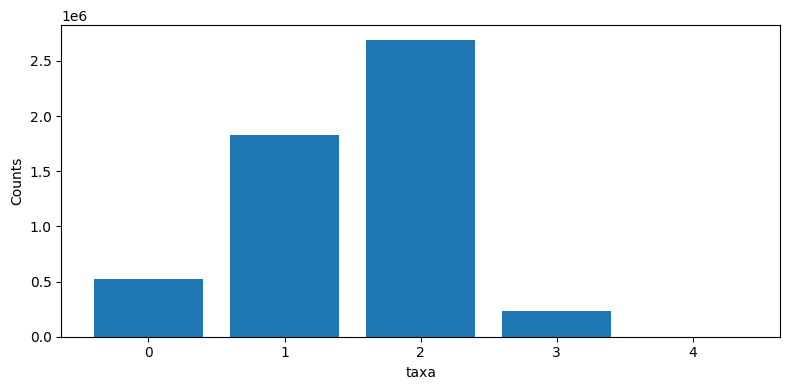

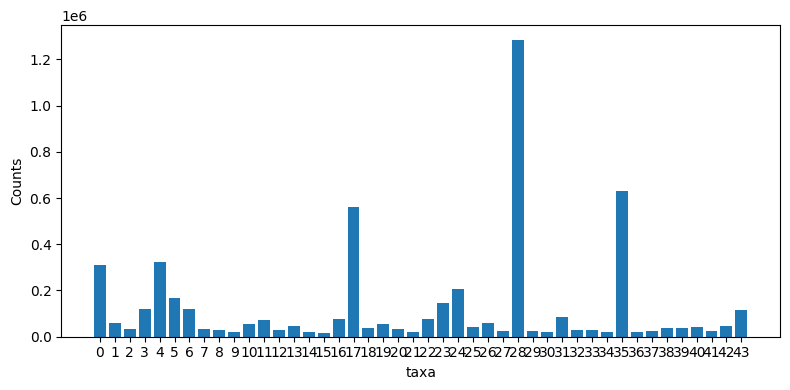

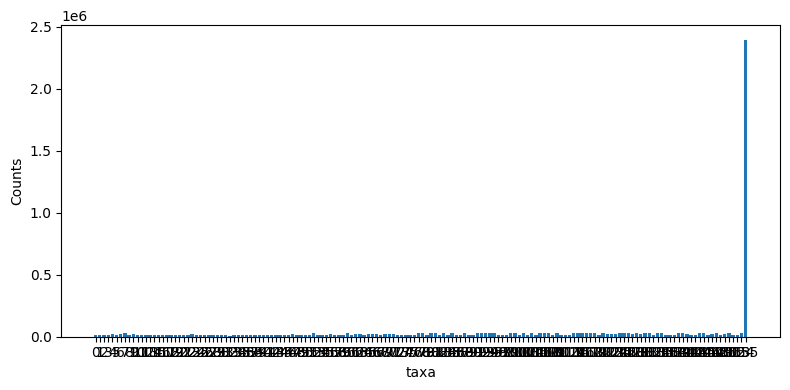

In [ ]:
import matplotlib.pyplot as plt

def plot_dict_bar(data: dict):
    counts = {}
    index = 0
    for taxon in sorted(data):
        counts[str(index)] = data[taxon]
        index += 1
    keys = list(counts.keys())
    counts = list(counts.values())
    plt.figure(figsize=(8, 4))
    plt.bar(keys, counts)
    plt.xlabel("taxa")
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.show()


plot_dict_bar(domain_grouping)
plot_dict_bar(phylum_grouping)
plot_dict_bar(genus_grouping)


In [ ]:
random.seed(7)


def prepare_datasets(
        mapping: dict,
        n_test: int,
        n_max_training: int,
        validation_fraction: float,
        dst: str
        ) -> tuple:
    """Split read IDs into test, train, and validation sets.

    Args:
        mapping: Map an index to a taxonomy.
        n_test: Number of reads for each taxon in the test set.
        validation_fraction: Fraction of non-test data used for validation.
        dst: Save directory.
    """
    taxon_to_read_IDs = {k: [] for k in mapping}
    reversed_mapping = {tuple(v): k for k, v in mapping.items()}
    granularity = len(mapping["0"])
    # Count reads in each taxon.
    i = 0
    for domain in BERTAX_DOMAINS:
        print(f"Inspecting `{domain}`.")
        with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
            current_ID = None
            for line in tqdm(f):
                if line.startswith(">"):
                    tax_id = line.strip()
                    tax_id = tax_id.replace(">", "")
                    tax_id = tax_id.split(" ")[0]
                    if tax_id in lookup_table:
                        current_taxon = lookup_table[tax_id][:granularity]
                        if current_taxon in reversed_mapping:
                            current_ID = reversed_mapping[current_taxon]
                        else:
                            current_ID = reversed_mapping[("unknown", )]
                elif current_ID:
                    sequence = line.strip().upper()
                    characters = set(sequence)
                    if len(characters) == 4:
                        taxon_to_read_IDs[current_ID].append(i)
                        i += 1
    # Split reads into distinct sets.
    train = {k: [] for k in mapping}
    validation = {k: [] for k in mapping}
    test = {k: [] for k in mapping}
    for taxon in taxon_to_read_IDs:
        random.shuffle(taxon_to_read_IDs[taxon])
        test[taxon] = taxon_to_read_IDs[taxon][:n_test]
        if len(taxon_to_read_IDs[taxon]) > n_max_training:
            train_data = taxon_to_read_IDs[taxon][n_test:n_test + n_max_training]
        else:
            train_data = taxon_to_read_IDs[taxon][n_test:]
        cutoff = int(len(train_data) * validation_fraction)
        train[taxon] = train_data[cutoff:]
        validation[taxon] = train_data[:cutoff]
    # Generate data.
    for name, data in zip(("test", "train", "validate"), (test, train, validation)):
        print(f"{name} set.")
        elements = set()
        for indices in data.values():
            elements.update(indices)
        N = sum([len(v) for v in data.values()])
        with tqdm(total=N) as progress_bar:
            assert N == len(elements), "Unexpected counts."
            x = np.zeros((N, BERTAX_READ_LENGTH // 4), dtype=np.uint8)
            y = np.zeros(N, dtype=np.uint16)
            i = 0
            local_i = 0
            for domain in BERTAX_DOMAINS:
                with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
                    current_ID = None
                    for line in tqdm(f):
                        if line.startswith(">"):
                            tax_id = line.strip()
                            tax_id = tax_id.replace(">", "")
                            tax_id = tax_id.split(" ")[0]
                            if tax_id in lookup_table:
                                current_taxon = lookup_table[tax_id][:granularity]
                                if current_taxon in reversed_mapping:
                                    current_ID = reversed_mapping[current_taxon]
                                else:
                                    current_ID = reversed_mapping[("unknown", )]
                        elif current_ID:
                            sequence = line.strip().upper()
                            characters = set(sequence)
                            if len(characters) == 4:
                                if i in elements:
                                    encoding = format.encode_tetramer(sequence)
                                    x[local_i] = encoding
                                    y[local_i] = int(current_ID)
                                    local_i += 1
                                    elements.remove(i)
                                i += 1
                                progress_bar.update(1)
            assert local_i == N
            mkdir(dst + name)
            np.save(dst + name + "/x.npy", x)
            np.save(dst + name + "/y.npy", y)


with open(BERTAX_STATISTIC_DIRECTORY + "genus_indices.json") as file:
    mapping = json.load(file)
prepare_datasets(mapping, BERTAX_N_TEST_READ_PER_TAXON, MAX_NUMBER_OF_READS_PER_CLASS, 0.05, BERTAX_GENUS)

Inspecting `Archaea_db.fa`.


1070306it [00:39, 26955.97it/s]


Inspecting `Bacteria_db.fa`.


3806366it [02:18, 27516.03it/s]


Inspecting `Eukaryota_db.fa`.


5415562it [03:08, 28669.24it/s]


Inspecting `Viruses_db.fa`.


507606it [00:16, 30102.51it/s]


test set.


1070306it [00:41, 25682.54it/s]                           
3806366it [02:27, 25870.61it/s]
5415562it [03:52, 23243.38it/s]
507606it [00:17, 28369.69it/s]]
5388074it [07:20, 12235.38it/s]


train set.


1070306it [01:18, 13693.18it/s] [01:18<04:57, 6818.37it/s]
3806366it [07:56, 7990.45it/s]20 [09:14<1:21:47, 25.95it/s] 
5415562it [1:05:24, 1379.83it/s]                               
507606it [00:21, 23516.19it/s]/s]
5388074it [1:15:11, 1194.36it/s] 


validate set.


1070306it [00:47, 22683.73it/s]                           
3806366it [02:26, 25900.03it/s]
5415562it [03:45, 24026.71it/s]
507606it [00:19, 26680.85it/s]]
5388074it [07:19, 12268.94it/s]


In [ ]:
with open(BERTAX_STATISTIC_DIRECTORY + "phylum_indices.json") as file:
    mapping = json.load(file)
prepare_datasets(mapping, BERTAX_N_TEST_READ_PER_TAXON, 2_000_000, 0.05, BERTAX_PHYLUM)

Inspecting `Archaea_db.fa`.


1070306it [00:38, 27746.08it/s]


Inspecting `Bacteria_db.fa`.


3806366it [02:11, 28852.29it/s]


Inspecting `Eukaryota_db.fa`.


5415562it [03:09, 28634.58it/s]


Inspecting `Viruses_db.fa`.


507606it [00:17, 28251.23it/s]


test set.


1070306it [00:39, 26964.38it/s]                         
3806366it [02:22, 26773.29it/s]
5415562it [03:21, 26848.14it/s]
507606it [00:24, 20820.36it/s]]
5388074it [06:48, 13196.87it/s]


train set.


1070306it [02:21, 7584.19it/s]3 [02:21<22:16, 3366.06it/s]
3806366it [08:06, 7830.93it/s]93 [10:27<11:51, 3652.13it/s]
5415562it [11:52, 7599.03it/s]                             
507606it [01:04, 7863.72it/s]]
5388074it [23:40, 3794.00it/s]


validate set.


1070306it [00:45, 23477.21it/s]                           
3806366it [02:32, 24997.29it/s]
5415562it [03:40, 24595.01it/s]
507606it [00:22, 22477.95it/s]]
5388074it [07:21, 12204.70it/s]


In [ ]:
total = 0
for domain in BERTAX_DOMAINS:
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        for line in f:
            if line.startswith(">"):
                total += 1
    print(f"Domain: {domain}. Total: {total}")

x = np.zeros((total, BERTAX_READ_LENGTH // 4), dtype=np.uint8)
i = 0
for domain in BERTAX_DOMAINS:
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        for line in f:
            if not line.startswith(">"):
                sequence = line.strip().upper()
                characters = set(sequence)
                if len(characters) == 4:
                    encoding = format.encode_tetramer(sequence)
                    x[i] = encoding
                    i += 1
np.save(PROCESSED_PRETRAINING_DATA + "/x.npy", x)

## 1.2. Validate Data

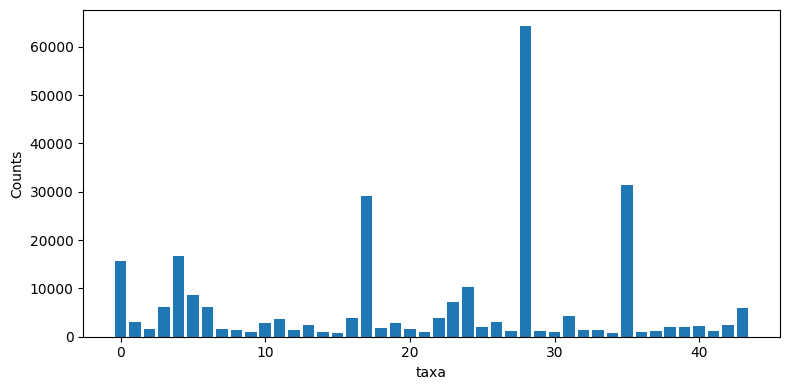

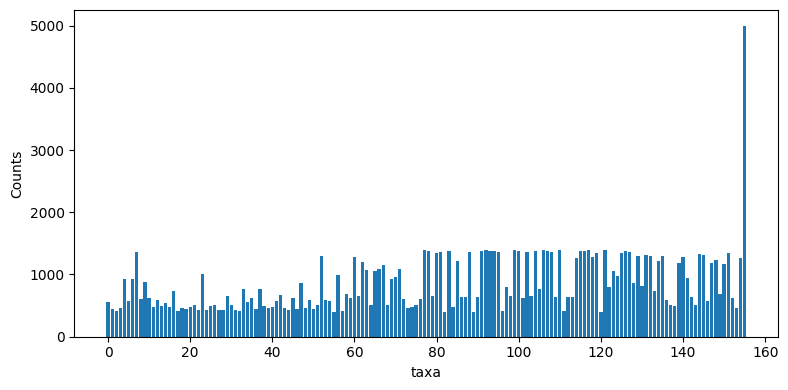

In [ ]:
def plot_dict_bar(path: dict):
    y = np.load(path + "validate/y.npy")
    _, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(8, 4))
    plt.bar(list(range(len(counts))), counts)
    plt.xlabel("taxa")
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.show()


plot_dict_bar(BERTAX_PHYLUM)
plot_dict_bar(BERTAX_GENUS)

## 1.3. Train Classification Models

### 1.3.1. Load Data

In [ ]:
import numpy as np
from torch.utils.data import DataLoader
import json
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch import save, load, nn
import time


def load_data(
        classification_dir: str,
        mapping_filepath: str,
        pretraining_dir: str = None,
        batch_size: int = 128,
        ):
    train_data = DataLoader(
        models.SyntheticTetramerDataset(classification_dir + "train/"),
        batch_size=batch_size,
        shuffle=True
    )
    validation_data = DataLoader(
        models.SyntheticTetramerDataset(classification_dir + "validate/"),
        batch_size=batch_size,
        shuffle=True
    )
    test_data = DataLoader(
        models.SyntheticTetramerDataset(classification_dir + "test/"),
        batch_size=batch_size,
        shuffle=True
    )
    with open(mapping_filepath, "r") as f:
        mapping = json.load(f)
    if pretraining_dir:
        pretraining_data = DataLoader(
            models.SyntheticTetramerDataset(PROCESSED_PRETRAINING_DATA, labels=False),
            batch_size=batch_size,
            shuffle=True
        )
    else:
        pretraining_data = False
    return train_data, validation_data, test_data, mapping, pretraining_data


def pretrain(classifier, cache_directory: str, n_steps: int, pretraining_data) -> None:
    optimizer = Adam(classifier.get_parameters(), lr=0.001)
    losses = classifier.pretrain(
        pretraining_data,
        optimizer,
        max_batches=n_steps,
        vocab_size=256,
        patience=20,
        probability=0.15,
        evaluation_interval=1000,
        pretraining_type="mlm"
    )
    print(f"Training losses: {losses}")
    save(classifier.model.state_dict(), f"{cache_directory}pretrain_mlm_weights_{n_steps // 1000}k_steps.pt2")


def train_classifier(
        classifier, cache_directory: str, epochs: tuple[int], train_data, validation_data
    ) -> None:
    parameters = classifier.get_parameters()
    total_params = sum(param.numel() for param in parameters)
    print(f"Number of parameters: {total_params:_}")
    optimizer = Adam(classifier.get_parameters(), lr=0.001)
    losses, validation_losses, f1, p = [], [], [], []
    for epoch in epochs:
        print(f"Epoch {epoch}")
        losses_, validation_losses_, f1_, p_ = classifier.train(
            train_data,
            validation_data,
            optimizer,
            max_n_epochs=1,
            patience=200,
            loss_function=nn.CrossEntropyLoss(),
            loss_function_type="supervised",
            evaluation_interval=5000,
            evaluation_maximum_duration=30.0,
            patience_interval=5000,
            n_max_steps=100_000
        )
        print(f"Training losses: {losses_}")
        print(f"Validation losses: {validation_losses_}")
        print(f"F1 scores: {f1_}")
        print(f"Precisions: {p_}")
        losses += losses_
        validation_losses += validation_losses_
        f1 += f1_
        p += p_
        save(classifier.model.state_dict(), f"{cache_directory}weights_{epoch}_epoch.pt2")

    print(f"Training losses: {losses}")
    print(f"Validation losses: {validation_losses}")
    print(f"F1 scores: {f1}")
    print(f"Precisions: {p}")


def test_speed(classifier, N):
    parameters = classifier.get_parameters()
    total_params = sum(param.numel() for param in parameters)
    print(f"Number of parameters: {total_params:_}")
    optimizer = Adam(classifier.get_parameters(), lr=0.001)
    a = time.time()
    classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=1,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=N * 2,
        evaluation_maximum_duration=30.0,
        patience_interval=N * 2,
        n_max_steps=N
    )
    delta = time.time() - a
    average = delta / N
    print(f"Average time for {N} steps: {average}.")


# train_data, validation_data, test_data, mapping, pretraining_data = load_data(
#     BERTAX_GENUS,
#     BERTAX_STATISTIC_DIRECTORY + "genus_indices.json",
#     BERTAX_PRETRAINING_DIRECTORY,
#     128
# )

train_data, validation_data, test_data, mapping, pretraining_data = load_data(
    BERTAX_PHYLUM,
    BERTAX_STATISTIC_DIRECTORY + "phylum_indices.json",
    BERTAX_PRETRAINING_DIRECTORY,
    128
)

### 1.3.2. Test Models

#### 1.3.2.1. Mamba From Scratch

In [8]:
directory = f"{BERTAX_MODELS}mamba/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
# pretrain(classifier, directory, 20_000, pretraining_data)
# train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
# models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)
classifier.model.load_state_dict(load(f"{directory}/weights_160k_steps.pt2"))
test_speed(classifier, 100)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

  0%|          | 99/20040 [00:13<44:30,  7.47it/s] 


Average time for 100 steps: 0.13261816024780274.


100%|██████████| 2438/2438 [01:36<00:00, 25.27it/s]


F1 score: [np.float64(0.7723071652038909), np.float64(0.9064195131488626), np.float64(0.7245233331150073)]


KeyboardInterrupt: 

#### 1.3.2.2. Mamba-Global From Scratch

In [ ]:
directory = f"{BERTAX_MODELS}mamba_global/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaMemorySequenceClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.3. Encoder-Only Transformer From Scratch

In [ ]:
directory = f"{BERTAX_MODELS}transformer/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
    ),
    format.to_tetramers,
    True
)

# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.4. Pretrainined Mamba

MLM

In [ ]:
directory = f"{BERTAX_MODELS}mamba_pretrained/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
# pretrain(classifier, directory, 20_000, pretraining_data)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
classifier.model.load_state_dict(load(f"{directory}/20k_mlm/weights_80k_steps.pt2"))
train_classifier(classifier, f"{directory}/20k_mlm/", (5, 6, 7, 8, ), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

In [ ]:
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

Causal

In [ ]:
directory = f"{BERTAX_MODELS}mamba_pretrained/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses = []
# classifier.model.load_state_dict(load(f"{directory}pretrain_causal_weights_20k_steps.pt2"))
for total_n_steps in (20, 40, ):
    losses_ = classifier.pretrain(
        pretraining_data,
        optimizer,
        max_batches=20_000,
        vocab_size=256,
        patience=20,
        probability=0.15,
        evaluation_interval=1000,
        pretraining_type="causal"
    )
    print(f"Training losses: {losses_}")
    losses += losses_
    save(classifier.model.state_dict(), f"{directory}pretrain_causal_weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")

In [ ]:
directory = f"{BERTAX_MODELS}mamba_pretrained/20k_causal/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_causal_weights_20k_steps.pt2"))
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)

In [ ]:
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.5. Pretrainined Mamba-Memory

In [ ]:
directory = f"{BERTAX_MODELS}mamba_global_pretrained/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaMemorySequenceClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
pretrain(classifier, directory, 20_000, pretraining_data)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.6. Pretrained Encoder-Only Transformer

In [ ]:
directory = f"{BERTAX_MODELS}transformer_pretrained/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
    ),
    format.to_tetramers,
    True
)
pretrain(classifier, directory, 20_000, pretraining_data)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.7. Mamba from Scratch, 3-mer

In [ ]:
directory = f"{BERTAX_MODELS}mamba_3mer/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=64,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_codons,
    True
)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
test_speed(classifier, 100)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

/mnt/d/maitrise/stelaro/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of parameters: 504_029
Epoch 1


 25%|██▍       | 5000/20040 [15:54<47:46,  5.25it/s]  

Halting evaluation after 76416 data points.
Halting evaluation after 76928 data points.


 25%|██▍       | 5001/20040 [17:44<138:10:19, 33.08s/it]

Halting evaluation after 76416 data points.
1/1 F1: [0.77355, 0.78361, 0.51624]. Precision: [0.77432, 0.77821, 0.55476] 
Training loss: 896.78181. Validation loss: 695.02849. Patience: 200


 50%|████▉     | 10000/20040 [34:27<32:06,  5.21it/s]   

Halting evaluation after 76800 data points.
Halting evaluation after 77312 data points.


 50%|████▉     | 10001/20040 [36:17<92:02:32, 33.01s/it]

Halting evaluation after 76032 data points.
1/1 F1: [0.81015, 0.8389, 0.58497]. Precision: [0.81743, 0.84605, 0.62259] 
Training loss: 640.89182. Validation loss: 592.41845. Patience: 200


 75%|███████▍  | 15000/20040 [52:12<16:04,  5.23it/s]   

Halting evaluation after 76544 data points.
Halting evaluation after 77184 data points.


 75%|███████▍  | 15001/20040 [53:58<45:01:13, 32.16s/it]

Halting evaluation after 76032 data points.
1/1 F1: [0.82198, 0.85587, 0.61287]. Precision: [0.83156, 0.86421, 0.65447] 
Training loss: 570.10031. Validation loss: 548.26540. Patience: 200


100%|█████████▉| 20000/20040 [1:11:26<00:07,  5.23it/s]  

Halting evaluation after 77312 data points.
Halting evaluation after 77568 data points.


100%|█████████▉| 20001/20040 [1:13:13<21:04, 32.42s/it]

Halting evaluation after 76032 data points.
1/1 F1: [0.82176, 0.86781, 0.63832]. Precision: [0.83132, 0.8712, 0.66325] 
Training loss: 530.81769. Validation loss: 515.35480. Patience: 200


100%|██████████| 20040/20040 [1:13:21<00:00,  4.55it/s]


Training loss: 530.81769. Validation loss: 515.35480. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [896.7818147510291, 640.8918185502291, 570.1003104329109, 530.8176860958338]
Validation losses: [695.0284916551868, 592.4184545874596, 548.265397247642, 515.3547959270501]
F1 scores: [array([0.77355321, 0.81015057, 0.8219808 , 0.82176042]), array([0.7836119 , 0.83889831, 0.8558715 , 0.86781133]), array([0.51624253, 0.58496544, 0.61287202, 0.63831749])]
Precisions: [array([0.77431608, 0.81743393, 0.83155699, 0.83131848]), array([0.77821306, 0.8460487 , 0.86421274, 0.87119954]), array([0.55476144, 0.62258803, 0.65446875, 0.6632516 ])]
Epoch 2


 25%|██▍       | 5000/20040 [15:56<47:54,  5.23it/s]  

Halting evaluation after 77440 data points.
Halting evaluation after 77568 data points.


 25%|██▍       | 5001/20040 [17:44<136:01:14, 32.56s/it]

Halting evaluation after 76160 data points.
1/1 F1: [0.83692, 0.88013, 0.65247]. Precision: [0.83974, 0.8916, 0.6896] 
Training loss: 499.45543. Validation loss: 498.99619. Patience: 200


 50%|████▉     | 10000/20040 [35:12<31:55,  5.24it/s]   

Halting evaluation after 76800 data points.
Halting evaluation after 76928 data points.


 50%|████▉     | 10001/20040 [36:59<89:50:29, 32.22s/it]

Halting evaluation after 76160 data points.
1/1 F1: [0.83931, 0.88513, 0.66831]. Precision: [0.83514, 0.89459, 0.69891] 
Training loss: 481.52744. Validation loss: 474.53444. Patience: 200


 75%|███████▍  | 15000/20040 [54:25<16:06,  5.21it/s]   

Halting evaluation after 77056 data points.
Halting evaluation after 77056 data points.


 75%|███████▍  | 15001/20040 [56:12<45:07:05, 32.23s/it]

Halting evaluation after 76672 data points.
1/1 F1: [0.84544, 0.89003, 0.66913]. Precision: [0.84828, 0.90065, 0.69632] 
Training loss: 467.80514. Validation loss: 467.72973. Patience: 200


100%|█████████▉| 20000/20040 [1:12:07<00:07,  5.25it/s] 

Halting evaluation after 77568 data points.
Halting evaluation after 77696 data points.


100%|█████████▉| 20001/20040 [1:13:54<20:57, 32.26s/it]

Halting evaluation after 76160 data points.
1/1 F1: [0.84491, 0.89628, 0.68383]. Precision: [0.84238, 0.90776, 0.71447] 
Training loss: 456.76603. Validation loss: 454.20799. Patience: 200


100%|██████████| 20040/20040 [1:14:01<00:00,  4.51it/s]


Training loss: 456.76603. Validation loss: 454.20799. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [499.4554267957807, 481.52744264155626, 467.8051354944706, 456.7660338297486]
Validation losses: [498.9961890488111, 474.53444136791865, 467.7297289985448, 454.2079867685542]
F1 scores: [array([0.83691954, 0.83931493, 0.84543912, 0.84490675]), array([0.88013218, 0.88512992, 0.89002789, 0.89627726]), array([0.65246667, 0.66830625, 0.6691331 , 0.68382793])]
Precisions: [array([0.83974427, 0.8351439 , 0.84828139, 0.84237974]), array([0.89159609, 0.89459152, 0.9006536 , 0.90776008]), array([0.68960294, 0.69891057, 0.69631588, 0.71447422])]
Epoch 3


 25%|██▍       | 5000/20040 [15:54<48:16,  5.19it/s]  

Halting evaluation after 76928 data points.
Halting evaluation after 76928 data points.


 25%|██▍       | 5001/20040 [17:41<134:10:47, 32.12s/it]

Halting evaluation after 76160 data points.
1/1 F1: [0.85027, 0.8913, 0.68346]. Precision: [0.85786, 0.89257, 0.70968] 
Training loss: 438.77018. Validation loss: 448.50797. Patience: 200


 50%|████▉     | 10000/20040 [35:14<31:46,  5.27it/s]   

Halting evaluation after 77696 data points.
Halting evaluation after 77056 data points.


 50%|████▉     | 10001/20040 [37:01<90:02:42, 32.29s/it]

Halting evaluation after 76288 data points.
1/1 F1: [0.85065, 0.89674, 0.69197]. Precision: [0.84928, 0.90412, 0.71285] 
Training loss: 432.72491. Validation loss: 439.93050. Patience: 200


 75%|███████▍  | 15000/20040 [54:30<16:03,  5.23it/s]   

Halting evaluation after 77184 data points.
Halting evaluation after 77184 data points.


#### 1.3.2.8. Mamba-CNN

100%|██████████| 2438/2438 [01:48<00:00, 22.48it/s]


F1 score: [np.float64(0.7832038127669296), np.float64(0.9144627752783364), np.float64(0.7407302268382758)]
Macro precision score: [np.float64(0.7767413425120658), np.float64(0.9276289135145086), np.float64(0.7698204826171341)]
Weighted precision score: [np.float64(0.9883788385017387), np.float64(0.9591028102546224), np.float64(0.7698204826171341)]


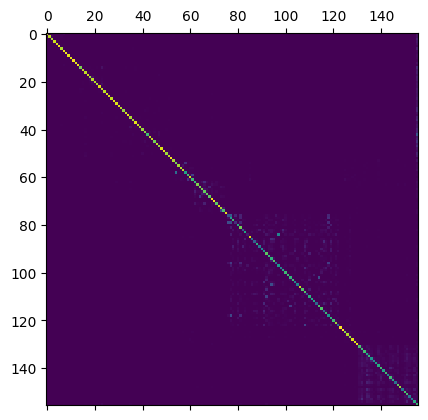

In [7]:
directory = f"{BERTAX_MODELS}cnn_mamba/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifierCNN(
        N=None,
        num_classes=len(mapping),
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_channels,
    True
)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
# train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
classifier.model.load_state_dict(load(f"{directory}/weights_160k_steps.pt2"))
test_speed(classifier, 100)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.9. Mamba-Memory-CNN

In [ ]:
directory = f"{BERTAX_MODELS}mamba_memory_cnn/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifierMemoryCNN(
        N=None,
        num_classes=len(mapping),
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_channels,
    True
)
pretrain(classifier, directory, 20_000, pretraining_data)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.10. Random Forest

In [ ]:
K = 6
N_TRAINING_SAMPLES = 100_000
N_TEST_SAMPLE = 20_000


def sample(data, limit: int, formatter: any) -> tuple:
    x, y = [], []
    i = 0
    for x_batch, y_batch in tqdm(data):
        for xi, yi in zip(x_batch, y_batch):
            x.append(formatter(xi))
            y.append(yi)
            i += 1
            if limit is not None and i >= limit:
                break
        if limit is not None and i >= limit:
            break
    x = np.array(x)
    y = np.array(y)
    _, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(8, 4))
    plt.bar(list(range(len(counts))), counts)
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.show()
    assert sum(counts) == limit
    return x, y


def kmer_counts(x: torch.Tensor, K) -> torch.Tensor:
    L = x.shape[0]
    if L < K:
        raise ValueError("Sequence length must be >= k")
    shifts = torch.tensor([6, 4, 2, 0]).view(1, 1, 4)
    x = x.unsqueeze(dim=-1)
    tokens = (x >> shifts) & 0b11
    seq = tokens.view(L * 4)
    num_kmers = 4 ** K
    base = torch.tensor([4**i for i in reversed(range(K))], device=seq.device)
    kmers = torch.stack([seq[i:i + K] for i in range(L - K + 1)], dim=0)
    kmer_ids = (kmers * base).sum(dim=-1)
    counts = torch.zeros(num_kmers, device=seq.device, dtype=torch.float32)
    counts.scatter_add_(0, kmer_ids, torch.ones_like(kmer_ids, dtype=torch.float32))
    counts = counts / counts.sum()
    return counts


x, y = sample(train_data, N_TRAINING_SAMPLES, lambda x: kmer_counts(x, K))
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    n_jobs=1,
)
rf.fit(x, y)
x_test, y_test = sample(test_data, N_TEST_SAMPLE, lambda x: kmer_counts(x, K))
y_pred = rf.predict(x_test)

mappings = models.obtain_rank_based_mappings(mapping)
result = models.rank_based_precision(mappings, y_test, y_pred)
rounded_result = [float(f"{r:.5}") for r in result[::-1]]
print(f"Macro Precision: {rounded_result}")

matrix = np.zeros((len(mapping), len(mapping)))
for t, p in zip(y_test, y_pred):
    matrix[t][p] += 1
plt.matshow(matrix)
plt.show()

#### 1.3.2.11. Large Transformer

In [ ]:
directory = f"{BERTAX_MODELS}transformer_large/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer


classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=200,
        vocab_size=256,
        n_head=4,
        n_layers=6,
        classification_type="token"
    ),
    format.to_tetramers,
    True
)
pretrain(classifier, directory, 20_000, pretraining_data)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.12. Residual Mamba

In [ ]:
directory = f"{BERTAX_MODELS}mamba_residual/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifierResidual(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.13. Mamba 2-mer

In [4]:
directory = f"{BERTAX_MODELS}mamba_2mer/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=16,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_pairs,
    True
)
# train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
# models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)
classifier.model.load_state_dict(load(f"{directory}/weights_8_epoch.pt2"))
test_speed(classifier, 200)
# models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

/mnt/d/maitrise/stelaro/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of parameters: 491_693


  1%|          | 199/20040 [01:00<1:40:00,  3.31it/s]

Average time for 200 steps: 0.3009234321117401.


#### 1.3.2.14. CLS Token-Based Transformer

Number of parameters: 927_517


  1%|          | 199/20040 [00:36<59:50,  5.53it/s]  


Average time for 200 steps: 0.18010965943336488.


100%|██████████| 2438/2438 [01:51<00:00, 21.84it/s]


F1 score: [np.float64(0.7331457359625536), np.float64(0.7984500049326588), np.float64(0.529637059286677)]
Macro precision score: [np.float64(0.7348424343343142), np.float64(0.8142673799465148), np.float64(0.5712864001434135)]
Weighted precision score: [np.float64(0.9599370324142468), np.float64(0.867315077635524), np.float64(0.5712864001434135)]


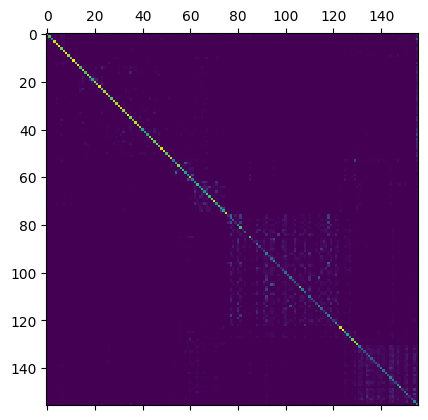

In [7]:
directory = f"{BERTAX_MODELS}transformer_token/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
        classification_type="token"
    ),
    format.to_tetramers,
    True
)
test_speed(classifier, 200)
classifier.model.load_state_dict(load(f"{directory}/weights_8_epoch.pt2"))
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)
# train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)

In [ ]:
classifier.model.load_state_dict(load(f"{directory}/weights_5_epoch.pt2"))
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.15. Pretrained CLS Token-Based Transformer

In [ ]:
from stelaro.models import transformer
directory = f"{BERTAX_MODELS}transformer_token_pretrained/"
mkdir(directory)

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
        classification_type="token"
    ),
    format.to_tetramers,
    True
)
pretrain(classifier, directory, 20_000, pretraining_data)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.16. CNN Transformer

In [6]:
from stelaro.models import transformer
directory = f"{BERTAX_MODELS}transformer_token_cnn/"
mkdir(directory)

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifierCNN(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
        classification_type="token"
    ),
    format.to_channels,
    True
)
test_speed(classifier, 200)
# classifier.model.load_state_dict(load(f"{directory}weights_7_epoch.pt2"))
# train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
# models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

Number of parameters: 1_047_453


  1%|          | 199/20040 [00:38<1:03:44,  5.19it/s]

Average time for 200 steps: 0.19182310104370118.


# 2. Long Sequence (5000 nt) Original Dataset

This section validates metagenomic classification models with an original synthetic read dataset
generated from RefSeq, an NCBI genome database, and GTDB, a phylogenomic database.

In [1]:
print("Defining values to parametrize the rest of the section.")

# Directory in which all data are to be written.
DATA_DIRECTORY = "../data/"

# Directory in which NCBI files summarizing the composition of RefSeq are to be stored.
SUMMARY_DIRECTORY = DATA_DIRECTORY + "ncbi_genome_summaries/"

# Directories in which taxonomy files are to be installed.
NCBI_TAXONOMY_DIRECTORY = DATA_DIRECTORY + "ncbi_taxonomy/"
TAXONOMY_DIRECTORY = DATA_DIRECTORY + "gtdb/"

# Number of reference genomes for each taxon to classify.
N_REFERENCE_GENOMES_PER_TAXON = 10

# Number of reference genomes for each taxon in the test set.
N_REFERENCE_GENOMES_TEST_SET = 4

# Number of synthetic samples in each reference genome.
N_READS_PER_REFERENCE_GENOME = 1000

# Proportion of reads used for the validation set.
VALIDATION_READ_PROPORTION = 0.05

# Length of the synthetic reads.
READ_LENGTH = 5000

# Name of the directory containing the original dataset.
LONG_READ_CLASSIFICATION_DIRECTORY = DATA_DIRECTORY + "long_dataset/"

# File containing the list of RefSeq reference genomes used to create synthetic reads.
GENOME_INDEX_FILE = LONG_READ_CLASSIFICATION_DIRECTORY + "index.tsv"

# File containing the initial binning of reference genomes.
GENOME_BINNING_FILE = LONG_READ_CLASSIFICATION_DIRECTORY + "bin.json"
TEST_GENOME_BINNING_FILE = LONG_READ_CLASSIFICATION_DIRECTORY + "test_bin.json"
NON_TEST_GENOME_BINNING_FILE = LONG_READ_CLASSIFICATION_DIRECTORY + "non_test_bin.json"

# File containing a dictionary that maps indices to taxa.
MAPPING_FILE = LONG_READ_CLASSIFICATION_DIRECTORY + "mapping.json"

# Directory to store raw NCBI reference genome data.
RAW_GENOME_DIRECTORY = LONG_READ_CLASSIFICATION_DIRECTORY + "raw_data/"

# Processed data directories.
TEST_DIRECTORY = LONG_READ_CLASSIFICATION_DIRECTORY + "test/"
NON_TEST_DIRECTORY = LONG_READ_CLASSIFICATION_DIRECTORY + "non_test/"
TRAINING_DIRECTORY = LONG_READ_CLASSIFICATION_DIRECTORY + "train/"
VALIDATION_DIRECTORY = LONG_READ_CLASSIFICATION_DIRECTORY + "validate/"

# Directories to store processed data.
TRAINED_MODELS = "trained_models/"
LONG_TRAINED_MODELS = "trained_models/long/"

Defining values to parametrize the rest of the section.


In [2]:
print("Importing modules and defining utility functions.")
import os
import json
import numpy as np
from stelaro.data import (
    ncbi,
    Taxonomy,
    gtdb,
    format,
    synthetic,
    get_urls,
    make_index_file,
)


def mkdir(path: str) -> None:
    """Create a directory if it does not exist."""
    if not os.path.exists(path):
        os.makedirs(path)


def rename(original: str, new: str) -> None:
    os.rename(original, new)

Importing modules and defining utility functions.


In [10]:
print("Configuring the environment.")
mkdir(DATA_DIRECTORY)
mkdir(LONG_READ_CLASSIFICATION_DIRECTORY)
mkdir(TEST_DIRECTORY)
mkdir(TRAINING_DIRECTORY)
mkdir(VALIDATION_DIRECTORY)
mkdir(TRAINED_MODELS)
mkdir(LONG_TRAINED_MODELS)
mkdir(RAW_GENOME_DIRECTORY)
mkdir(NON_TEST_DIRECTORY)

Configuring the environment.


## 2.1. Prepare Data

### 2.1.1. Download Reference Genomes

In [ ]:
mkdir(SUMMARY_DIRECTORY)
ncbi.install_summaries(SUMMARY_DIRECTORY)
ncbi.summarize_assemblies(SUMMARY_DIRECTORY)

archaea: 2 579 genomes
bacteria: 432 090 genomes
fungi: 644 genomes
invertebrate: 434 genomes
plant: 186 genomes
protozoa: 121 genomes
vertebrate mammalian: 239 genomes
vertebrate other: 432 genomes
viral: 14 997 genomes

Total: 451 722


In [7]:
gtdb.install_taxonomy(TAXONOMY_DIRECTORY)

In [8]:
with open(TAXONOMY_DIRECTORY + "/bac120_taxonomy.tsv") as f:
    count = 0
    print("First lines contained in the GTDB bacterial taxonomy file:\n\n```")
    for line in f:
        if count < 5:
            print(line[:-1])
        count += 1
    print(f"```\n\nTotal number of lines: {count}.")

First lines contained in the GTDB bacterial taxonomy file:

```
RS_GCF_009898805.1	d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli
RS_GCF_024700115.1	d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli
RS_GCF_003829795.1	d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli
RS_GCF_900480365.1	d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli
GB_GCA_003592305.1	d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli
```

Total number of lines: 715230.


The first column is the identifier of a reference genome. The second column is its taxonomy. Each
field of that column contains a prefix that indicates the taxonomic order:

- `d__`: Domain
- `p__`: Phylum
- `c__`: Class
- `o__`: Order
- `f__`: Family
- `g__`: Genus
- `s__`: Species

There are multiple *Escherichia coli* reference genomes because they correspond to different strains
within the same species.

We filter out taxonony identifiers to preserve only those that correspond to RefSeq reference
genomes.

In [ ]:
T = Taxonomy(("refseq", ))
urls = get_urls(SUMMARY_DIRECTORY)
T.read_GTDB_file(TAXONOMY_DIRECTORY + "/bac120_taxonomy.tsv", urls)
T.read_GTDB_file(TAXONOMY_DIRECTORY + "/ar53_taxonomy.tsv", urls)
del urls

In [ ]:
dataset = T.bin_genomes(
    depth=4,  # The dataset will have a resolution at the level of orders.
    granularity_level=0,  # Data points will be split by species.
    min_granularity=N_REFERENCE_GENOMES_PER_TAXON,  # The minimum number of species by bin.
    n_min_reference_genomes_per_bin=N_REFERENCE_GENOMES_PER_TAXON,  # Minimum number of reference genomes by species.
    n_max_reference_genomes_per_species=1,  # Maximum number of reference genomes for a species.
    max_bin_size=1,  # Maximum number of reference genomes by genus.
    n_max_bins=10  # Maximum number of data points for each class.
)

with open(GENOME_BINNING_FILE, "w") as file:
    file.write(json.dumps(dataset, indent=4))

# Convert the dataset into a list of URLs that can be downloaded.
with open(GENOME_BINNING_FILE, "r") as f:
    dataset = json.load(f)
make_index_file(dataset, GENOME_INDEX_FILE, SUMMARY_DIRECTORY)

In [ ]:
mapping = {}
for i in range(len(dataset)):
    mapping[str(i)] = dataset[i][0]

with open(MAPPING_FILE, "w") as file:
    file.write(json.dumps(mapping, indent=4))

In [ ]:
ncbi.install_genomes(RAW_GENOME_DIRECTORY, GENOME_INDEX_FILE)
# Or use the command line: `../../stelarilo install-genomes --input index.tsv --dst raw_data/`

In [ ]:
from random import shuffle

with open(GENOME_BINNING_FILE, "r") as file:
    dataset = json.load(file)

test, non_test = [], []
for taxonomy, bins in dataset:
    elements = bins.copy()
    shuffle(elements)
    n = len(elements)
    test.append([taxonomy, elements[:N_REFERENCE_GENOMES_TEST_SET]])
    non_test.append([taxonomy, elements[N_REFERENCE_GENOMES_TEST_SET:]])

with open(TEST_GENOME_BINNING_FILE, "w") as file:
    file.write(json.dumps(test, indent=4))
with open(NON_TEST_GENOME_BINNING_FILE, "w") as file:
    file.write(json.dumps(non_test, indent=4))

### 2.1.2. Generate Synthetic Reads for the Test Set

In [ ]:
with open(MAPPING_FILE, "r") as file:
    mapping = json.load(file)

with open(TEST_GENOME_BINNING_FILE, "r") as file:
    dataset = json.load(file)

index_to_n_passes = {}
for i in mapping:
    index_to_n_passes[i] = int(N_READS_PER_REFERENCE_GENOME * 1.1)
n = synthetic.write(
    dataset,
    mapping,
    index_to_n_passes,
    RAW_GENOME_DIRECTORY,
    READ_LENGTH,
    TEST_DIRECTORY,
    TEST_DIRECTORY + "reads.fasta"
)
print(f"Sampled {n} reads.")

Estimated file size: 3498.0 MB.
Average number of reads per bin: 4400.00


  6%|▌         | 42580/699600 [00:20<09:32, 1148.52it/s]

Error on GCF_036802725.1: Could not generate an acceptable read.


 14%|█▍        | 98807/699600 [00:53<04:08, 2414.50it/s]

Error on GCF_024197615.1: 'M'


 16%|█▋        | 115370/699600 [01:04<06:24, 1518.41it/s]

Error on GCF_000255705.1: Could not generate an acceptable read.


 21%|██▏       | 149264/699600 [01:28<03:04, 2988.36it/s]

Error on GCF_000714715.1: 'R'


 29%|██▊       | 199941/699600 [01:53<02:37, 3165.01it/s]

Error on GCF_029582805.1: 'R'


 32%|███▏      | 224792/699600 [02:07<05:15, 1507.23it/s]

Error on GCF_011682235.2: 'Y'


 34%|███▍      | 239646/699600 [02:13<02:34, 2982.14it/s]

Error on GCF_001746205.1: 'W'


 34%|███▍      | 241359/699600 [02:14<03:22, 2263.03it/s]

Error on GCF_009755975.1: 'K'


 64%|██████▍   | 450339/699600 [04:14<02:23, 1735.29it/s]

Error on GCF_002243385.1: Could not generate an acceptable read.


 72%|███████▏  | 503599/699600 [04:45<01:35, 2058.86it/s]

Error on GCF_016019935.1: 'W'


 72%|███████▏  | 504808/699600 [04:46<01:26, 2254.22it/s]

Error on GCF_036553665.1: 'Y'


 79%|███████▉  | 555316/699600 [05:15<01:06, 2158.40it/s]

Error on GCF_000510265.1: 'M'


 92%|█████████▏| 643357/699600 [06:05<00:26, 2107.43it/s]

Error on GCF_002414625.1: Could not generate an acceptable read.


 94%|█████████▍| 658533/699600 [06:14<00:16, 2434.65it/s]

The file ../data/long_dataset/raw_data/GCF_964212645.1.fna does not exist


 96%|█████████▋| 673970/699600 [06:22<00:10, 2385.31it/s]

Error on GCF_013464105.1: 'W'


100%|█████████▉| 698500/699600 [06:36<00:00, 1759.71it/s]


Sampled 698500 reads.


In [4]:
rename(TEST_DIRECTORY + "y.npy", TEST_DIRECTORY + "original_y.npy")
rename(TEST_DIRECTORY + "x.npy", TEST_DIRECTORY + "original_x.npy")

In [ ]:
y = np.load(TEST_DIRECTORY + "original_y.npy")
x = np.load(TEST_DIRECTORY + "original_x.npy")
sub_x, sub_y = synthetic.sample_per_class(x, y, N_READS_PER_REFERENCE_GENOME)
print("Sampled reads")
np.save(TEST_DIRECTORY + "y.npy", sub_y)
tetramer_x = synthetic.to_tetramers(sub_x)
np.save(TEST_DIRECTORY + "x.npy", tetramer_x)

Sampled reads


159000it [02:12, 1200.29it/s]


### 2.1.3. Generate Synthetic Reads for the Other Sets

In [ ]:
with open(MAPPING_FILE, "r") as file:
    mapping = json.load(file)

with open(NON_TEST_GENOME_BINNING_FILE, "r") as file:
    dataset = json.load(file)

index_to_n_passes = {}
for i in mapping:
    index_to_n_passes[i] = N_READS_PER_REFERENCE_GENOME
n = synthetic.write(
    dataset,
    mapping,
    index_to_n_passes,
    RAW_GENOME_DIRECTORY,
    READ_LENGTH,
    NON_TEST_DIRECTORY,
    NON_TEST_DIRECTORY + "reads.fasta"
)
print(f"Sampled {n} reads.")

Estimated file size: 4770.0 MB.
Average number of reads per bin: 6000.00


  2%|▏         | 16934/954000 [00:07<04:18, 3631.76it/s]

Error on GCF_011319475.1: Could not generate an acceptable read.


 11%|█         | 106947/954000 [00:55<04:49, 2926.67it/s]

Error on GCF_000348725.1: 'Y'


 16%|█▌        | 149369/954000 [01:18<05:06, 2623.26it/s]

Error on GCF_000021565.1: 'W'


 26%|██▌       | 245417/954000 [02:21<04:44, 2487.88it/s]

Error on GCF_000008565.1: 'S'


 28%|██▊       | 264379/954000 [02:34<09:48, 1172.57it/s]

Error on GCF_002251945.1: 'R'


 31%|███       | 294397/954000 [02:51<06:58, 1576.00it/s]

Error on GCF_000006985.1: 'Y'


 34%|███▍      | 328752/954000 [03:07<03:29, 2989.33it/s]

Error on GCF_002379365.1: Could not generate an acceptable read.


 38%|███▊      | 362385/954000 [03:25<04:37, 2129.48it/s]

Error on GCF_010470665.1: 'R'


 85%|████████▌ | 811373/954000 [07:43<01:11, 1983.31it/s]

Error on GCF_029169405.1: Could not generate an acceptable read.


100%|██████████| 954000/954000 [09:04<00:00, 1751.63it/s]


Sampled 954000 reads.


In [4]:
rename(NON_TEST_DIRECTORY + "y.npy", NON_TEST_DIRECTORY + "original_y.npy")
rename(NON_TEST_DIRECTORY + "x.npy", NON_TEST_DIRECTORY + "original_x.npy")

In [5]:
# Compress the dataset
x = np.load(NON_TEST_DIRECTORY + "original_x.npy")
tetramer_x = synthetic.to_tetramers(x)
np.save(NON_TEST_DIRECTORY + "original_x_tetramers.npy", tetramer_x)

954000it [13:34, 1170.59it/s]


In [11]:
x = np.load(NON_TEST_DIRECTORY + "original_x_tetramers.npy")
y = np.load(NON_TEST_DIRECTORY + "original_y.npy")
n_references = N_REFERENCE_GENOMES_PER_TAXON - N_REFERENCE_GENOMES_TEST_SET
total = N_READS_PER_REFERENCE_GENOME * n_references
n_validation_reads = int(total * VALIDATION_READ_PROPORTION)
n_train_reads = int(total * (1.0 - VALIDATION_READ_PROPORTION))
train, validate = synthetic.divide_dataset(x, y, (n_train_reads, n_validation_reads))
np.save(f"{TRAINING_DIRECTORY}x.npy", train[0])
np.save(f"{TRAINING_DIRECTORY}y.npy", train[1])
np.save(f"{VALIDATION_DIRECTORY}x.npy", validate[0])
np.save(f"{VALIDATION_DIRECTORY}y.npy", validate[1])

## 2.2. Validate Data

## 2.3. Train Classification Models

### 2.3.1. Load Data

In [3]:
from torch.utils.data import DataLoader
import json
from torch.optim import Adam
from stelaro import models
from torch import save, nn
import time

BATCH_SIZE = 64


def get_data():
    train_data = DataLoader(
        models.SyntheticTetramerDataset(TRAINING_DIRECTORY),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    validation_data = DataLoader(
        models.SyntheticTetramerDataset(VALIDATION_DIRECTORY),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    test_data = DataLoader(
        models.SyntheticTetramerDataset(TEST_DIRECTORY),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    with open(MAPPING_FILE, "r") as f:
        mapping = json.load(f)
    return train_data, validation_data, test_data, mapping


def train_classifier(
        classifier, cache_directory: str, epochs: tuple[int], train_data, validation_data
    ) -> None:
    parameters = classifier.get_parameters()
    total_params = sum(param.numel() for param in parameters)
    print(f"Number of parameters: {total_params:_}")
    optimizer = Adam(classifier.get_parameters(), lr=0.001)
    losses, validation_losses, f1, p = [], [], [], []
    for epoch in epochs:
        print(f"Epoch {epoch}")
        losses_, validation_losses_, f1_, p_ = classifier.train(
            train_data,
            validation_data,
            optimizer,
            max_n_epochs=1,
            patience=200,
            loss_function=nn.CrossEntropyLoss(),
            loss_function_type="supervised",
            evaluation_interval=4000,
            evaluation_maximum_duration=30.0,
            patience_interval=4000,
            n_max_steps=30_000
        )
        print(f"Training losses: {losses_}")
        print(f"Validation losses: {validation_losses_}")
        print(f"F1 scores: {f1_}")
        print(f"Precisions: {p_}")
        losses += losses_
        validation_losses += validation_losses_
        f1 += f1_
        p += p_
        save(classifier.model.state_dict(), f"{cache_directory}weights_{epoch}_epoch.pt2")

    print(f"Training losses: {losses}")
    print(f"Validation losses: {validation_losses}")
    print(f"F1 scores: {f1}")
    print(f"Precisions: {p}")


def test_speed(classifier, N):
    parameters = classifier.get_parameters()
    total_params = sum(param.numel() for param in parameters)
    print(f"Number of parameters: {total_params:_}")
    optimizer = Adam(classifier.get_parameters(), lr=0.001)
    a = time.time()
    classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=1,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=N * 2,
        evaluation_maximum_duration=30.0,
        patience_interval=N * 2,
        n_max_steps=N
    )
    delta = time.time() - a
    average = delta / N
    print(f"Average time for {N} steps: {average}.")


train_data, validation_data, test_data, mapping = get_data()

### 2.3.2. Train Classification Models

#### 2.3.2.1. Mamba

In [ ]:
directory = f"{LONG_TRAINED_MODELS}mamba/"
mkdir(directory)
from torch import load
from stelaro.models import ssm

classifier = models.Classifier(
    READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
classifier.model.load_state_dict(load(f"{directory}weights_4_epoch.pt2"))
# train_classifier(classifier, directory, (4, ), train_data, validation_data)
# models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)
test_speed(classifier, 200)
print(models.p_r_f1(classifier, test_data, "cuda"))

/mnt/d/maitrise/stelaro/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of parameters: 553_760


  1%|▏         | 199/14161 [00:55<1:04:21,  3.62it/s]


Average time for 200 steps: 0.27523727297782896.


100%|██████████| 2485/2485 [03:07<00:00, 13.26it/s]


(0.71781862722248, 0.711440251572327, 0.7022208499000043)


#### 2.3.2.2. Mamba-Memory

In [ ]:
directory = f"{LONG_TRAINED_MODELS}mamba_memory/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaMemorySequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
classifier.model.load_state_dict(load(f"{directory}weights_4_epoch.pt2"))
# train_classifier(classifier, directory, (4, ), train_data, validation_data)
# models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)
test_speed(classifier, 200)
print(models.p_r_f1(classifier, test_data, "cuda"))

Number of parameters: 817_056


  1%|▏         | 199/14161 [00:55<1:05:07,  3.57it/s]


Average time for 200 steps: 0.2784790861606598.


100%|██████████| 2485/2485 [03:12<00:00, 12.91it/s]


(0.7188155145877362, 0.7143333333333334, 0.7042739778944814)


#### 2.2.2.3. Mamba-CNN

In [ ]:
directory = f"{LONG_TRAINED_MODELS}mamba_cnn/"
mkdir(directory)
from torch import load
from stelaro.models import ssm

classifier = models.Classifier(
    READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifierCNN(
        N=None,
        num_classes=len(mapping),
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_channels,
    True
)
classifier.model.load_state_dict(load(f"{directory}weights_4_epoch.pt2"))
# train_classifier(classifier, directory, (4, ), train_data, validation_data)
# models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)
test_speed(classifier, 200)
print(models.p_r_f1(classifier, test_data, "cuda"))

Number of parameters: 640_543


  1%|▏         | 199/14161 [00:58<1:08:16,  3.41it/s]


Average time for 200 steps: 0.2919725930690765.


100%|██████████| 2485/2485 [03:27<00:00, 12.00it/s]


(0.7263800011159817, 0.7127547169811321, 0.7016339502146666)


#### 2.2.2.4. Mamba-Memory-CNN

In [ ]:
directory = f"{LONG_TRAINED_MODELS}mamba_memory_cnn/"
mkdir(directory)
from torch import load
from stelaro.models import ssm

classifier = models.Classifier(
    READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifierMemoryCNN(
        N=None,
        num_classes=len(mapping),
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_channels,
    True
)
classifier.model.load_state_dict(load(f"{directory}weights_4_epoch.pt2"))
# train_classifier(classifier, directory, (4, ), train_data, validation_data)
# models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)
test_speed(classifier, 200)
print(models.p_r_f1(classifier, test_data, "cuda"))

Number of parameters: 903_839


  1%|▏         | 199/14161 [01:00<1:11:16,  3.26it/s]


Average time for 200 steps: 0.30479692697525024.


100%|██████████| 2485/2485 [03:34<00:00, 11.57it/s]


(0.7222421007444808, 0.7147169811320755, 0.7020170710385946)


#### 2.2.2.5. Transformer

In [ ]:
directory = f"{LONG_TRAINED_MODELS}transformer/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer

classifier = models.Classifier(
    READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
        classification_type="token",
    ),
    format.to_tetramers,
    True
)
classifier.model.load_state_dict(load(f"{directory}weights_4_epoch.pt2"))
# train_classifier(classifier, directory, (4, ), train_data, validation_data)
# models.benchmark_classifier(classifier, test_data, "cuda", mapping, 400)
test_speed(classifier, 200)
print(models.p_r_f1(classifier, test_data, "cuda"))

Number of parameters: 1_039_648


  1%|▏         | 199/14161 [02:06<2:28:05,  1.57it/s]


Average time for 200 steps: 0.6332368767261505.


100%|██████████| 2485/2485 [06:22<00:00,  6.50it/s]


(0.5925595864711601, 0.5770880503144654, 0.5688694747919085)


#### 2.2.2.6. Transformer-CNN

Number of parameters: 1_159_840
Epoch 2


 28%|██▊       | 4000/14161 [43:52<1:51:12,  1.52it/s]

Halting evaluation after 12160 data points.
Halting evaluation after 12416 data points.


 28%|██▊       | 4001/14161 [45:26<81:32:37, 28.89s/it]

Halting evaluation after 10176 data points.
1/1 F1: [0.96877, 0.90553, 0.89286, 0.84553]. Precision: [0.97485, 0.91911, 0.90353, 0.86068] 
Training loss: 854.34173. Validation loss: 813.54592. Patience: 200


 56%|█████▋    | 8000/14161 [1:29:16<1:07:45,  1.52it/s]

Halting evaluation after 12224 data points.
Halting evaluation after 12416 data points.


 57%|█████▋    | 8001/14161 [1:30:51<49:19:21, 28.82s/it]

Halting evaluation after 10112 data points.
1/1 F1: [0.97394, 0.91092, 0.894, 0.85215]. Precision: [0.9753, 0.90333, 0.90059, 0.86986] 
Training loss: 753.33178. Validation loss: 712.75569. Patience: 200


 85%|████████▍ | 12000/14161 [2:16:00<24:27,  1.47it/s]  

Halting evaluation after 11520 data points.
Halting evaluation after 11840 data points.


 85%|████████▍ | 12001/14161 [2:17:35<17:23:22, 28.98s/it]

Halting evaluation after 9664 data points.
1/1 F1: [0.98155, 0.92967, 0.91928, 0.87185]. Precision: [0.98651, 0.94251, 0.92755, 0.88506] 
Training loss: 682.16810. Validation loss: 612.01080. Patience: 200


100%|██████████| 14161/14161 [2:41:46<00:00,  1.46it/s]   


Training loss: 682.16810. Validation loss: 612.01080. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [854.3417287059128, 753.3317849505693, 682.1681019989774]
Validation losses: [813.5459241720866, 712.755685436386, 612.0107954503685]
F1 scores: [array([0.9687732 , 0.97394274, 0.98154955]), array([0.90553226, 0.91092303, 0.92967191]), array([0.89286113, 0.89399928, 0.91927524]), array([0.84552512, 0.85215315, 0.87185223])]
Precisions: [array([0.97485101, 0.9753037 , 0.98650817]), array([0.91911201, 0.90333221, 0.94250771]), array([0.90352503, 0.90058942, 0.92755411]), array([0.86068099, 0.86986398, 0.88506131])]
Epoch 3


 28%|██▊       | 4000/14161 [44:40<1:51:45,  1.52it/s]

Halting evaluation after 12224 data points.
Halting evaluation after 12352 data points.


 28%|██▊       | 4001/14161 [46:15<81:31:19, 28.89s/it]

Halting evaluation after 10112 data points.
1/1 F1: [0.97652, 0.93151, 0.92366, 0.88757]. Precision: [0.96709, 0.92928, 0.92087, 0.89072] 
Training loss: 599.73985. Validation loss: 610.02002. Patience: 200


 56%|█████▋    | 8000/14161 [1:30:09<1:07:38,  1.52it/s]

Halting evaluation after 12224 data points.
Halting evaluation after 11968 data points.


 57%|█████▋    | 8001/14161 [1:31:44<49:40:36, 29.03s/it]

Halting evaluation after 10112 data points.
1/1 F1: [0.97079, 0.92625, 0.92178, 0.87617]. Precision: [0.96604, 0.93315, 0.92151, 0.88648] 
Training loss: 577.59106. Validation loss: 587.18186. Patience: 200


 85%|████████▍ | 12000/14161 [2:15:52<23:59,  1.50it/s]  

Halting evaluation after 12032 data points.
Halting evaluation after 12160 data points.


 85%|████████▍ | 12001/14161 [2:17:27<17:30:03, 29.17s/it]

Halting evaluation after 9984 data points.
1/1 F1: [0.98388, 0.94409, 0.93807, 0.89805]. Precision: [0.98788, 0.93951, 0.93897, 0.90618] 
Training loss: 552.30376. Validation loss: 521.02272. Patience: 200


100%|██████████| 14161/14161 [2:41:10<00:00,  1.46it/s]   


Training loss: 552.30376. Validation loss: 521.02272. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [599.7398461215198, 577.59105628822, 552.3037611274049]
Validation losses: [610.0200206229958, 587.1818597793956, 521.0227193310857]
F1 scores: [array([0.97651548, 0.97078938, 0.9838815 ]), array([0.93150942, 0.92624556, 0.94408585]), array([0.92366122, 0.92177706, 0.93806706]), array([0.88756819, 0.87616847, 0.898053  ])]
Precisions: [array([0.9670852 , 0.96603969, 0.98787538]), array([0.92927723, 0.93315451, 0.93950551]), array([0.92087291, 0.9215113 , 0.93896641]), array([0.89072277, 0.88648443, 0.90618087])]
Training losses: [854.3417287059128, 753.3317849505693, 682.1681019989774, 599.7398461215198, 577.59105628822, 552.3037611274049]
Validation losses: [813.5459241720866, 712.755685436386, 612.0107954503685, 610.0200206229958, 587.1818597793956, 521.0227193310857]
F1 scores: [array([0.9687732 , 0.97394274, 0.98154955]), array([0.90553226, 0.910923

100%|██████████| 2485/2485 [06:27<00:00,  6.41it/s]


F1 score: [np.float64(0.9298234307216551), np.float64(0.7384225332716778), np.float64(0.7380865761058295), np.float64(0.6339104213572512)]
Macro precision score: [np.float64(0.9111297906938771), np.float64(0.7579793883952296), np.float64(0.7545988347177025), np.float64(0.6531954724229916)]
Weighted precision score: [np.float64(0.9807768368896964), np.float64(0.8319265812072769), np.float64(0.7899271549848809), np.float64(0.6531954724229916)]


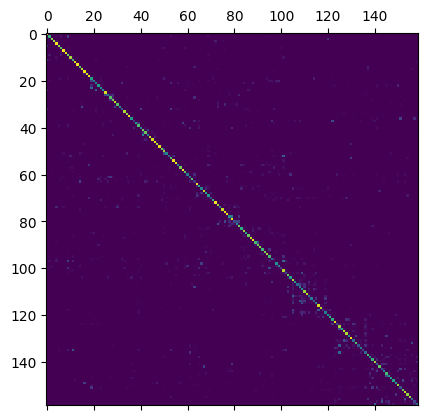

In [5]:
directory = f"{LONG_TRAINED_MODELS}transformer_cnn/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer


classifier = models.Classifier(
    READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifierCNN(
        N=READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
        classification_type="token"
    ),
    format.to_channels,
    True
)

classifier.model.load_state_dict(load(f"{directory}weights_1_epoch.pt2"))
train_classifier(classifier, directory, (2, 3, ), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 400)

In [6]:
test_speed(classifier, 200)
print(models.p_r_f1(classifier, test_data, "cuda"))

Number of parameters: 1_159_840


  1%|▏         | 199/14161 [02:07<2:29:22,  1.56it/s]


Average time for 200 steps: 0.6387437999248504.


100%|██████████| 2485/2485 [06:30<00:00,  6.36it/s]


(0.6577584059497491, 0.6461132075471698, 0.6377928804771262)
